# Instacart Market Basket Analysis: Customer's Diet and Their Next Order List


### Before doing any extensive analysis, I made a list of questions that got me curious about the data. I used this list as a guide in my analysis.  

### QUESTIONS TO ANSWER USING THE DATA
1.	How many products?
2.	How many aisles?
3.	How many department?
4.	How many customers?
5.	How many total orders?
6.	Are there missing data? What type of missing data?
7.	When are the peak hours (orders>100,000)? When is the orders highest and lowest?
8.	What day of the week has the highest and lowest order volume?
9.	What is the probability of each product being ordered?
10.	What is the probability of each department being ordered from?
11.	What is the probability of each aisle being ordered from?
12.	Can I identify meat eaters, vegetarian, vegan their percentage in the entire customer list? (Hypothesis Testing is in section)
13.	What is the probability of customers being meat eater, vegetarian or vegan? (I used Bayesian Statistic in this part)
14.	What products appear in all customer A orders? – These products will have high probability being reordered by customer A
15.	How many orders for each customer?
16.	What is the average number of products for across all orders for each customer?
17. Using average number of product per order for each customer and probability of product to be reordered by customer, can I predict products that will be reordered by customer?
18.	What is the accuracy of my predicted next order list to the actual next order list?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib import rcParams
from scipy import stats
sns.set(style="whitegrid", color_codes=True)
sns.set_context("poster")

In [2]:
prod=pd.read_csv('products.csv')
prod.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


## Q1. How many products? 

In [3]:
prod.product_id.max()  #number of products available

49688

## Q2. How many aisles?

In [4]:
prod.aisle_id.max()

134

## Q3. How many departments?

In [5]:
prod.department_id.max()

21

In [6]:
orders=pd.read_csv('orders.csv')
orders.head()    #order_dow days of the week

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


## Q4. How many customers? 

In [7]:
orders.user_id.unique().size

206209

## Q5. How many total orders?


In [8]:
orders.order_id.size

3421083

In [9]:
### Maximum number of order for a customer
orders.order_number.max()  

100

In [10]:
## User_id of customer with maximum order of 100
orders.set_index('user_id').order_number.idxmax()

210

## Q1-Q5 ANSWERS
There are a total of 7 csv files used in data analysis namely: 
1) aisles, 2) departments, 3) order_products_prior, 4) order_products_train, 5) orders, 6) products, 7) sample_submission

Querying 5) orders and 6) products we now know that there are 

### 49,688      PRODUCTS
### 134           AISLES
### 21             DEPARMENTS
### 206,209    CUSTOMERS
### 3,421,083 ORDERS

Customer with user_id 210 has odered the most of 100 orders.

## orders dataframe has 3 eval_set (prior, train, test)
prior has the most number of orders and contains order history of users while train and set has latest orders of selected users that can be use for training a model and testing a model

Prior Set= 3,214,874 orders,  Train Set = 131, 209 orders, Test Set =75,000 orders


In [11]:
orders.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

## orders dataframe is separated to the 3 eval_set

In [12]:
oprior=orders[orders.eval_set=='prior']
otrain=orders[orders.eval_set=='train']
otest=orders[orders.eval_set=='test']

## Q6. Are there missing data? 
### Yes only in orders dataframe. There are - 206, 209 "NaN" in days_since_prior_order  column which are the first order of all 206,209 users. This is a MAR (missing at random) type of missing data.

In [13]:
orders.isnull().sum()      #missing values in days_since_prior_order = users first order in INSTACART

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [14]:
prod.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [15]:
aisles=pd.read_csv('aisles.csv')
aisles.isnull().sum()

aisle_id    0
aisle       0
dtype: int64

In [16]:
dep=pd.read_csv('departments.csv')     
dep.isnull().sum()      

department_id    0
department       0
dtype: int64

In [17]:
prior=pd.read_csv('order_products__prior.csv')
prior.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [18]:
train=pd.read_csv('order_products__train.csv')
train.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [19]:
samp=pd.read_csv('sample_submission.csv')
samp.isnull().sum()

order_id    0
products    0
dtype: int64

## Q7. When are peak hours when order>100,000? (8am to 10pm) 

### When are orders highest and lowest? (lowest at 3am and highest at 10am)

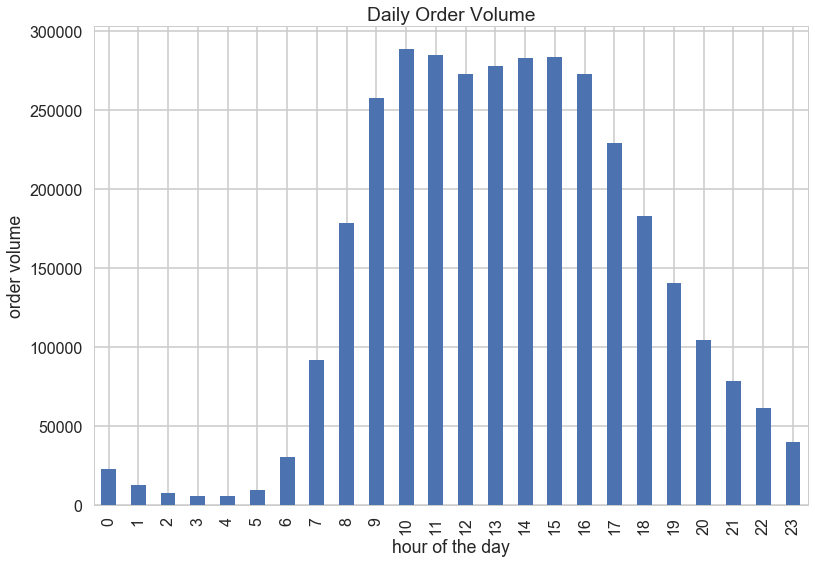

In [20]:
hourdist=orders['order_hour_of_day'].value_counts().sort_index()
hourdist.plot(kind='bar')
_=plt.xlabel('hour of the day')
_=plt.ylabel('order volume')
_=plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
plt.title('Daily Order Volume')

In [21]:
## These are the peak hours (8-20 orders are over 100,000)
hourdist[hourdist>100000]

8     178201
9     257812
10    288418
11    284728
12    272841
13    277999
14    283042
15    283639
16    272553
17    228795
18    182912
19    140569
20    104292
Name: order_hour_of_day, dtype: int64

In [22]:
hourdist.idxmax()

10

In [23]:
hourdist.idxmin()

3

## Q8. What day of the week is order volume higest and lowest?                                                    

## (Highest on Mondays and lowest on Fridays)

In [25]:
orday=orders.order_dow.value_counts()

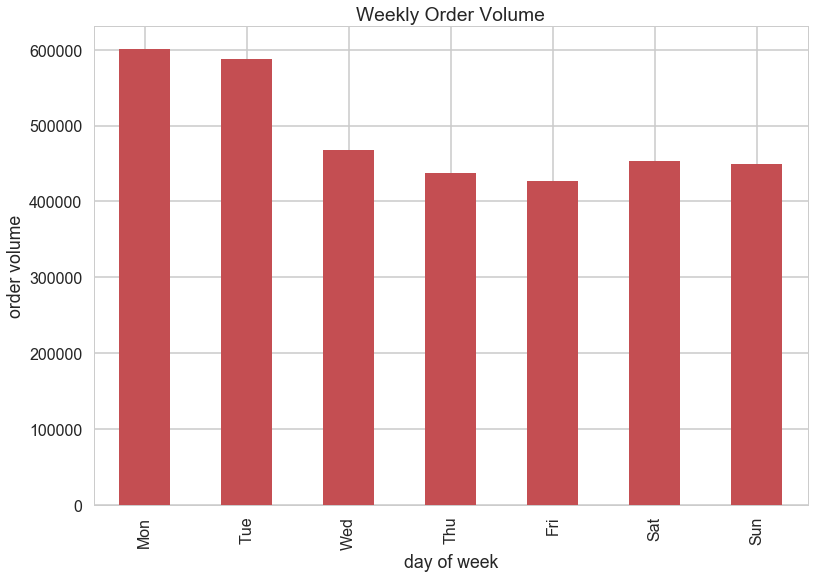

In [26]:
orday.sort_index().plot(kind='bar', color='r')
_=plt.xlabel('day of week')
_=plt.ylabel('order volume')
_=plt.xticks([0,1,2,3,4,5,6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Weekly Order Volume')

In [27]:
orday.idxmax()


0

In [28]:
orday.idxmin()

4

## Q7-Q8 ANSWERS
Peak hours where orders are above 100,000 / hour are at 8am to 10 pm.  Highest order is at 10 am and lowest is at 3am. Order volume are at high on Mondays and Tuesdays, starts slowing down on Wednesdays, at minimum on Fridays and picks up a little on the weekend.  This means that the website must be at optimum performance on peak hours 8am-10pm and the days when order volume are at high.  When choosing what day and hour to do the website maintenance that will require down time, Friday between 12am to 6am will be the best day and time.

## MERGING DATAFRAMES


### USING "otrain" dataframe

In [29]:
## alltrain has latest order of selected users but does not include their order history
alltrain=otrain.merge(train).merge(prod).merge(dep).merge(aisles)

In [30]:
alltrain.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,1187899,1,train,11,4,8,14.0,196,1,1,Soda,77,7,beverages,soft drinks
1,2757217,67,train,25,0,11,5.0,196,1,1,Soda,77,7,beverages,soft drinks
2,632715,676,train,12,0,13,26.0,196,2,1,Soda,77,7,beverages,soft drinks
3,1167274,760,train,5,4,10,8.0,196,2,1,Soda,77,7,beverages,soft drinks
4,3347074,804,train,16,3,21,5.0,196,4,0,Soda,77,7,beverages,soft drinks


In [31]:
## Number rows,columns in alltrain
alltrain.shape

(1384617, 15)

In [32]:
## Number of user_id in alltrain
alltrain.user_id.unique().size

131209

In [33]:
## Number of orders in alltrain
alltrain.order_id.unique().size

131209

In [34]:
#Average number of products per order in alltrain
alltrain.groupby('order_id')['product_name'].size().mean()

10.552759338155157

### USING "oprior" dataframe

In [35]:
allprior=oprior.merge(prior).merge(prod).merge(dep).merge(aisles)

In [36]:
allprior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,beverages,soft drinks
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,beverages,soft drinks
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,beverages,soft drinks
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,beverages,soft drinks
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,beverages,soft drinks


In [37]:
## Number of rows, columns in allprior
allprior.shape

(32434489, 15)

In [38]:
## Number of user_id in allprior
allprior.user_id.unique().size

206209

In [39]:
## Number of orders in allprior
allprior.order_id.unique().size

3214874

## Q9. What is the probability of a specific product being ordered?

In [40]:
## Probability of Products being ordered using "alltrain"
ProbA=alltrain.product_name.value_counts()
ProbA=pd.DataFrame(ProbA)
ProbA['PA(ordered)']=ProbA['product_name']/alltrain.product_name.size
ProbA=ProbA.reset_index()
ProbA.columns=['product_name','count','PA(ordered)']
ProbA.head(10)

,product_name,count,PA(ordered)
0,Banana,18726,0.013524
1,Bag of Organic Bananas,15480,0.011180
2,Organic Strawberries,10894,0.007868
3,Organic Baby Spinach,9784,0.007066
4,Large Lemon,8135,0.005875
5,Organic Avocado,7409,0.005351
6,Organic Hass Avocado,7293,0.005267
7,Strawberries,6494,0.004690
8,Limes,6033,0.004357
9,Organic Raspberries,5546,0.004005


In [41]:
## Probability of Products being ordered using "allprior"
ProbB=allprior.product_name.value_counts()
ProbB=pd.DataFrame(ProbB)
ProbB['PB(ordered)']=ProbB['product_name']/allprior.product_name.size
ProbB=ProbB.reset_index()
ProbB.columns=['product_name','count','PB(ordered)']
ProbB.head(10)

,product_name,count,PB(ordered)
0,Banana,472565,0.014570
1,Bag of Organic Bananas,379450,0.011699
2,Organic Strawberries,264683,0.008161
3,Organic Baby Spinach,241921,0.007459
4,Organic Hass Avocado,213584,0.006585
5,Organic Avocado,176815,0.005451
6,Large Lemon,152657,0.004707
7,Strawberries,142951,0.004407
8,Limes,140627,0.004336
9,Organic Whole Milk,137905,0.004252


## Q10. What is the probability of each department being ordered from?


In [42]:
## Probability of Department being ordered from using "alltrain"
ProbDA=alltrain.department.value_counts()
ProbDA=pd.DataFrame(ProbDA)
ProbDA['PDA(ordered)']=ProbDA['department']/alltrain.department.size
ProbDA.head(10)

,department,PDA(ordered)
produce,409087,0.295451
dairy eggs,217051,0.156759
snacks,118862,0.085845
beverages,114046,0.082366
frozen,100426,0.072530
pantry,81242,0.058675
bakery,48394,0.034951
canned goods,46799,0.033799
deli,44291,0.031988
dry goods pasta,38713,0.027959


In [43]:
## Probability of Department being ordered from using "allprior"
ProbDB=allprior.department.value_counts()
ProbDB=pd.DataFrame(ProbDB)
ProbDB['PDB(ordered)']=ProbDB['department']/allprior.department.size
ProbDB.head(10)

,department,PDB(ordered)
produce,9479291,0.292260
dairy eggs,5414016,0.166922
snacks,2887550,0.089027
beverages,2690129,0.082940
frozen,2236432,0.068952
pantry,1875577,0.057827
bakery,1176787,0.036282
canned goods,1068058,0.032930
deli,1051249,0.032411
dry goods pasta,866627,0.026719


## Q11. What is the probability of each aisle being ordered from?


In [44]:
## Probability of Aisle being ordered from using "alltrain"
aisle_percenta=alltrain.aisle_id.value_counts()/alltrain.aisle_id.size
aisle_percenta=pd.DataFrame(aisle_percenta).sort_index().reset_index()
aisle_percenta.columns=['aisle_id', 'aisle_percent_train']

In [45]:
##Percentage/probability of orders coming from each aisle using allprior 
aisle_percentb=allprior.aisle_id.value_counts()/allprior.aisle_id.size
aisle_percentb=pd.DataFrame(aisle_percentb).sort_index().reset_index()
aisle_percentb.columns=['aisle_id', 'aisle_percent_prior']

In [46]:
aisle_percent=aisle_percenta.merge(aisle_percentb)
aisle_percent.head()

,aisle_id,aisle_percent_train,aisle_percent_prior
0,1,0.002120,0.002218
1,2,0.002797,0.002543
2,3,0.012602,0.014071
3,4,0.007162,0.006187
4,5,0.002098,0.001927


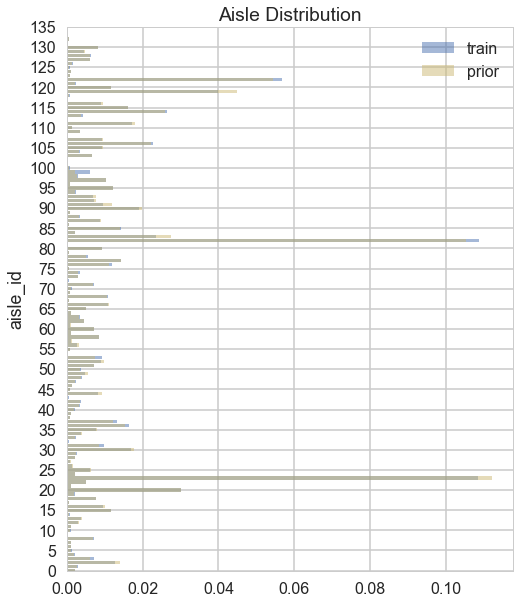

In [47]:
fig, ax = plt.subplots(figsize=(8,10))
y=np.arange(134)
plt.barh(range(len(aisle_percenta.aisle_percent_train)), aisle_percenta.aisle_percent_train, color='b', alpha=0.5)
plt.barh(range(len(aisle_percentb.aisle_percent_prior)), aisle_percentb.aisle_percent_prior, color='y', alpha=0.5)
plt.ylim(0,135)
plt.ylabel('Percent')
plt.ylabel('aisle_id')
plt.title('Aisle Distribution')
plt.legend(['train', 'prior'], loc='upper right')
ax.set_yticks(np.arange(0,136,5))
plt.show()

## Q12. Can you classify the customer as MEAT_LOVERS, PESCATARIAN, NONVEGAN AND VEGAN Vegetarians?

I have simplified classifying these 4 groups by looking at what aisles customers order from. 
Meat_Lovers will for sure have meat and seafood products from aisles 5, 7, 15, 34, 35, 39, 49, 95, 96, 106 and 122 
Pescatarians will for sure only have seafood products from aisles 15, 34, 39 and 95
NonVegans will not eat any from the meat and seafood from aisles 5, 7, 15, 34, 35, 39, 49, 95, 96, 106 and 122

Vegans will not eat any from the meat and seafood from aisles 5, 7, 15, 34, 35, 39, 49, 95, 96, 106 and 122 and any dairy products like milk, cheeses and creamsin aisles 2, 21, 53, 84, 86, 108, and 120

#### Q12A. Different Functions are written that will be used to classify the four diet groups
#### Q12B. Diet Classifications will be identified by USERS
#### Q12C. Diet Classifications will be identified by ORDERS
#### Q12D. Generation of Simulated Datasets
#### Q12E. Hypothesis Testing part 1: Are there significant differences between Diet distributions classified by USERS vs. by ORDERS?
#### Q12F: hypothesis testing part 2: Are there significant differences between Diet distribution classified by USERS and by ORDERS using Empirical dataset vs. Simulated dataset 



In [48]:
## U is the dataframe of users with their maximum number of orders using "oprior"
U=oprior.groupby('user_id')['order_number'].agg(['max'])
U['user_id']=U.index.get_level_values('user_id').values
U.columns=['max_order', 'user_id']

In [49]:
## P_num is the dataframe of users with order_id and the number of products per order using "allprior"
P_num=allprior.groupby('user_id')['order_id'].value_counts()
P_num=pd.DataFrame(P_num)
P_num.columns=['prod_per_order']
P_num['user_id']=P_num.index.get_level_values('user_id').values
P_num['order_id']=P_num.index.get_level_values('order_id').values

In [50]:
### Tot_p is the dataframe of users with total number of products they ordered using allprior
Tot_p=allprior.user_id.value_counts()
Tot_p=pd.DataFrame(Tot_p).reset_index()
Tot_p.columns=['user_id', 'total_products']

### Q12A. Functions used to identify Diet Classifications

### F1. This function provides a sample of "n" random users from the oprior dataframe for training dataset

In [51]:
def Sample_maker(Q):  ## User_Max_Or is s dataframe with user_id and their maximum order_number, n is number of samples
    PO=Q.merge(P_num).merge(Tot_p)
    sample1=Q.sample(n=30000, replace=False, random_state=0, axis=0)
    
    ## sample1 is the DataFrame of the first dataset
    sample1=sample1.merge(PO, how='inner')
    sample1=sample1.loc[:,['user_id', 'order_id', 'max_order', 'prod_per_order', 'total_products']]


    #Emp is the Empirical dataframe
    Emp=sample1.merge(allprior, how='inner')
    
    return Emp

### F2. This Function classifies Users as Meat_Lovers, Pescatarian, Vegan, NonVegan according to users overall order history

In [52]:
def Diet_Class_user(A): ## A is a  dataframe produced from "Sample_maker" function
    ## Total products ordered from Meat & Seafood Aisles
    MS=A[(A.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==15)|(A.aisle_id==34)|(A.aisle_id==35)|(A.aisle_id==39)|(A.aisle_id==49)|(A.aisle_id==95)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    
    ##Eats Meat and Fish
    M=MS[(MS.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==35)|(A.aisle_id==49)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    MF=M.user_id.unique()
    Meat_L=pd.DataFrame(MF, columns=['user_id'])
    Meat_L['Diet']='Meat_Lovers'
    
    ##Pescatarian that eat and not eat other meat
    P=MS[(MS.aisle_id==15)|(MS.aisle_id==34)|(MS.aisle_id==39)|(MS.aisle_id==95)]
    F=P.user_id.unique()
    
    ## Pescatarian customers
    Pesca=np.setdiff1d(F,MF)
    Pesca=pd.DataFrame(Pesca, columns=['user_id'])
    Pesca['Diet']='Pescatarian'

    ## All Vegetarians
    Veg=A.loc[~A.user_id.isin(MS.user_id)]

    # NonVegan 
    NV=Veg[(Veg.aisle_id==86)|(Veg.aisle_id==2)|(Veg.aisle_id==21)|(Veg.aisle_id==53)|(Veg.aisle_id==84)|(Veg.aisle_id==108)|(Veg.aisle_id==120)]
    F1=NV.user_id.unique()

    NonVeg=pd.DataFrame(F1, columns=['user_id'])
    NonVeg['Diet']='NonVegan'
    
    ##Vegans
    Vegans=Veg.loc[~Veg.user_id.isin(F1)]
    Vega=Vegans.user_id.unique()
    Vega=pd.DataFrame(Vega, columns=['user_id'])
    Vega['Diet']='Vegan'
    
    ## Merge all DataFrame of Different Diets
    Sample_class=pd.concat([Meat_L, Pesca, NonVeg, Vega])
    
    return Sample_class

### F3. This Function classifies Meat_Lovers, Pescatarian, Vegan, NonVegan according to orders and disregarding who ordered it (the user)

In [53]:
def Diet_Class_orders(A):
    ## Total products ordered from Meat & Seafood Aisles
    MS=A[(A.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==15)|(A.aisle_id==34)|(A.aisle_id==35)|(A.aisle_id==39)|(A.aisle_id==49)|(A.aisle_id==95)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    
    ##Eats Meat and Fish
    M=MS[(MS.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==35)|(A.aisle_id==49)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    MF=M.order_id.unique()
    Meat_L=pd.DataFrame(MF, columns=['order_id'])
    Meat_L['Diet']='Meat_Lovers'
    
    ##Pescatarian that eat and not eat other meat
    P=MS[(MS.aisle_id==15)|(MS.aisle_id==34)|(MS.aisle_id==39)|(MS.aisle_id==95)]
    F=P.order_id.unique()
    
    ## Pescatarian customers
    Pesca=np.setdiff1d(F,MF)
    Pesca=pd.DataFrame(Pesca, columns=['order_id'])
    Pesca['Diet']='Pescatarian'

    ## All Vegetarians
    Veg=A.loc[~A.order_id.isin(MS.order_id)]

    # NonVegan 
    NV=Veg[(Veg.aisle_id==86)|(Veg.aisle_id==2)|(Veg.aisle_id==21)|(Veg.aisle_id==53)|(Veg.aisle_id==84)|(Veg.aisle_id==108)|(Veg.aisle_id==120)]
    F1=NV.order_id.unique()

    NonVeg=pd.DataFrame(F1, columns=['order_id'])
    NonVeg['Diet']='NonVegan'
    
    ##Vegans
    Vegans=Veg.loc[~Veg.order_id.isin(F1)]
    Vega=Vegans.order_id.unique()
    Vega=pd.DataFrame(Vega, columns=['order_id'])
    Vega['Diet']='Vegan'
    
    ## Merge all DataFrame of Different Diets
    Sample_class=pd.concat([Meat_L, Pesca, NonVeg, Vega])
    
    return Sample_class

### F4. This function returns a horizontal bar graph of distrubution of the four Diet Categories of Customers 

In [54]:
def Diet_Percentage(B):
    Per=B.Diet.value_counts()
    Per=pd.DataFrame(Per).reset_index()
    Per.columns=['Diet','Size']
    Per['Percent']=Per.Size/Per.Size.sum()
    
    return Per

### F5. This function excludes the 'n' users previously used in generating a sample training data set from oprior


In [55]:
def Remaining_users(S): ## S is an Empirical Sample Generated DataFrame (E1, E2, E3)
    Rem=U.loc[~U.user_id.isin(S.user_id)]
    return Rem

### F6. This function generates simulated sample dataframe

In [56]:
def Simulated_sample(S):  # S isn an empirical sample generated dataframe (E1,E2, E3)
    G=S.loc[:, ['user_id', 'order_id', 'prod_per_order']]
    G=G.drop_duplicates()
    
    ## G.prod_per_order is turned into a list n.  n will be used on a loop to generate a simulated order dataframe
    n=pd.Series.tolist(G.prod_per_order)

    ## This will generate the simulated orders where aisle is randomly picked accoring to its calculated probability or percentage from aisle_percent dataframe
    B=[]
    for i in n:
        Q=np.random.choice(a=aisle_percentb.aisle_id, size=i, p=aisle_percent.aisle_percent_prior)
        Q=Q.tolist()
        B.append(Q)
    
    ## The simulated list of randomly picked aisles "B" is turned into dataframe 
        
    Sim1=pd.DataFrame(B).reset_index().stack()
    Sim1=pd.DataFrame(Sim1).reset_index()
    Sim1=Sim1.rename(columns={'level_0':'order_id', 'level_1':'product_num', 0:'aisle_id'})
    Sim1=Sim1[Sim1['product_num']!='index']
    Sim1['user_id']=S['user_id']
    
    return Sim1

### F7. This function will merge two dataframes from two group of proportions being compared 

In [57]:
## This function will merge two dataframes from two group of proportions being compared 
def df_prop_compare(M, N):    ## M and N are dataframes with Diet classification with Size and Percent
    M.columns=['Diet', 'Size1', 'Percent1']
    N.columns=['Diet', 'Size2', 'Percent2']
    MN=M.merge(N)
    return MN

### F8. This function calculates variance, standard deviation, difference in proportion, MOE, degrees of freedom, t_value and p_value

In [59]:
def diff_std_p_val(W):    ## W is a dataframe with the Diet classification Sizes and Percentages of 2 groups being compared
    W['var_1']=W.Percent1*(1-W.Percent1)/W.Size1
    W['var_2']=W.Percent2*(1-W.Percent2)/W.Size2
    W['var1_2']=W.var_1+W.var_2
    W['std_var1_2']=  W.var1_2**0.5             ## a.k.a. standard error

    W['%_diff']=abs(W.Percent1-W.Percent2)      ## absolute difference between two proportions

    W['moe']=1.96*W.std_var1_2                   ## margin of error

    W['DF']= ((W.var_1/W.Size1 +W.var_2/W.Size2)**2)/(((W.var_1/W.Size1)**2/W.Size1)+((W.var_2/W.Size2)**2/W.Size2))  ## degrees of freedom

    W['t_val']=(W['%_diff']-0)/W.std_var1_2

    W['p_val']=stats.t.sf(np.abs(W.t_val), W.DF)*2  # two-sided pvalue = Prob(abs(t)>tt)

    return W   

### Q12B. Identifying Diet Classification by USERS
In this section Diets are identified by USERS using their order history.  E1, E2, and E3 are empirical sample dataframes each with 30,000 users.  P_user1, P_user2 and P_user3 are dataframes with the percentage of each diet classification

In [61]:
## First Empirical Sample with 30,000 users from oprior DataFrame
E1=Sample_maker(U)           # Empirical Sample Generated
C1=Diet_Class_user(E1)       # Diets are of 30,000 in the Empirical Sample Classified by USERS
P_user1=Diet_Percentage(C1)  # This returns the percentage of the different Diet Classification
P_user1

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,Meat_Lovers,19362,0.645400
1,NonVegan,6952,0.231733
2,Vegan,2230,0.074333
3,Pescatarian,1456,0.048533


In [62]:
## Second Empirical Sample with 30,000 users from oprior DataFrame
U1=Remaining_users(E1)      # The 30,000 users in the first Emprical Sample (E1) is excluded from the oprior DataFrame

E2=Sample_maker(U1)         # Empirical Sample Generated
C2=Diet_Class_user(E2)      # Diets are of 30,000 in the Empirical Sample Classified
P_user2=Diet_Percentage(C2) # This returns the percentage of the different Diet Classification
P_user2

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,Meat_Lovers,19567,0.652233
1,NonVegan,6845,0.228167
2,Vegan,2125,0.070833
3,Pescatarian,1463,0.048767


In [63]:
## Third Empirical Sample with 30,000 users from oprior DataFrame

ET=pd.concat([E1,E2])           # The first two Empirical Sample were merged a
U2=Remaining_users(ET)          # The 60,000 users in the first and second Emprical Sample (E1+E2) are excluded from the oprior DataFrame
E3=Sample_maker(U2)             # Empirical Sample Generated
C3=Diet_Class_user(E3)          # Diets are of 30,000 in the Empirical Sample Classified
P_user3=Diet_Percentage(C3)     # This returns the percentage of the different Diet Classification
P_user3

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,Meat_Lovers,19553,0.651767
1,NonVegan,6802,0.226733
2,Vegan,2204,0.073467
3,Pescatarian,1441,0.048033


### Bar Graph Comparison of % Diet Classification according to USERS across three Empirical Sample Datasets


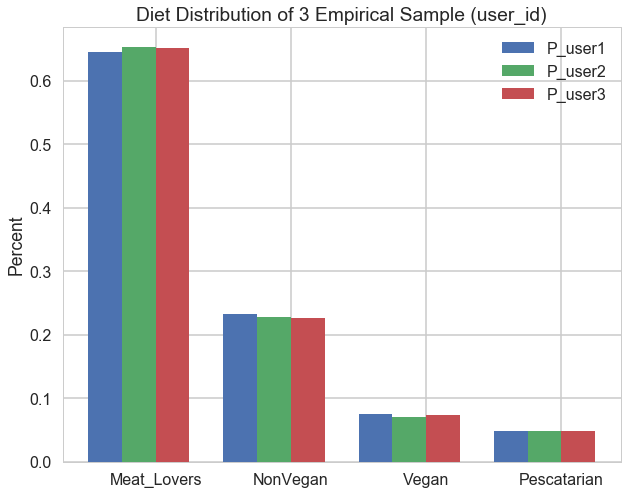

In [64]:
fig, ax = plt.subplots(figsize=(10,8))

X = np.arange(4)
plt.bar(X + 0.00, P_user1.Percent, color = 'b', width = 0.25)
plt.bar(X + 0.25, P_user2.Percent, color = 'g', width = 0.25)
plt.bar(X + 0.50, P_user3.Percent, color = 'r', width = 0.25)
plt.ylabel('Percent')

ax.set_xticks([p + 1.5 * 0.25 for p in X])
ax.set_xticklabels(P_user1.Diet)

plt.legend(['P_user1', 'P_user2', 'P_user3'], loc='upper right')
plt.title('Diet Distribution of 3 Empirical Sample (user_id)')
plt.show()

### Q12C. Identifying Diet Classification by ORDERS

In [65]:
## Reclassification of Diets using E1 
C_order1=Diet_Class_orders(E1)       # Diets are classified per order_id
P_order1=Diet_Percentage(C_order1)   # This returns the percentage and a bar graph distribution of the different Diet Classification
P_order1

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,NonVegan,185377,0.397996
1,Vegan,148928,0.319742
2,Meat_Lovers,116322,0.249738
3,Pescatarian,15149,0.032524


In [66]:
## Reclassification of Diets using E2 
C_order2=Diet_Class_orders(E2)          # Diets are classified per order_id
P_order2=Diet_Percentage(C_order2)      # This returns the percentage of the different Diet Classification
P_order2

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,NonVegan,184798,0.398264
1,Vegan,145945,0.314531
2,Meat_Lovers,118058,0.254430
3,Pescatarian,15208,0.032775


In [67]:
## Reclassification of Diets using E3 
C_order3=Diet_Class_orders(E3)          # Diets are classified per order_id
P_order3=Diet_Percentage(C_order3)      # This returns the percentage of the different Diet Classification
P_order3

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,NonVegan,188442,0.400391
1,Vegan,149141,0.316886
2,Meat_Lovers,117445,0.249541
3,Pescatarian,15617,0.033182


### Bar Graph Comparison of % Diet Classification according to USERS across three Empirical Sample Datasets

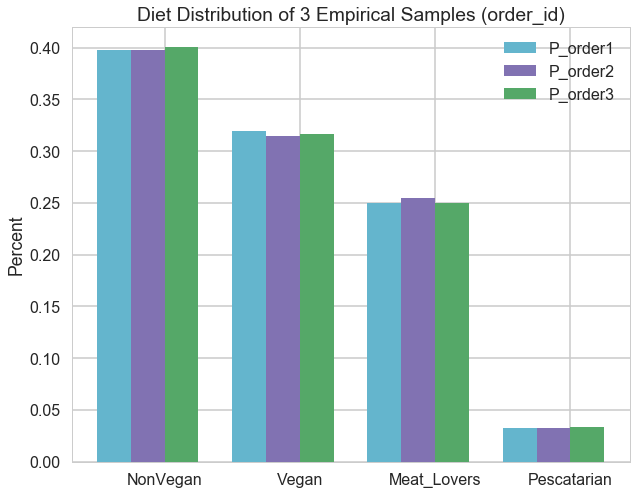

In [68]:
## Bar Graph comparison of Diet distribution using Empirical Samples classified using ORDERS
fig, ax = plt.subplots(figsize=(10,8))

X = np.arange(4)
plt.bar(X + 0.00, P_order1.Percent, color = 'c', width = 0.25)
plt.bar(X + 0.25, P_order2.Percent, color = 'm', width = 0.25)
plt.bar(X + 0.50, P_order3.Percent, color = 'g', width = 0.25)
plt.ylabel('Percent')

ax.set_xticks([p + 1.5 * 0.25 for p in X])
ax.set_xticklabels(P_order1.Diet)

plt.legend(['P_order1', 'P_order2', 'P_order3'], loc='upper right')
plt.title('Diet Distribution of 3 Empirical Samples (order_id)')
plt.show()


### Q12D. Generation of Simulated Datasets

In [69]:
## This is the first simulated Sample dataframe with randomly picked aisles
Simu1= Simulated_sample(E1)

In [70]:
#Simulated_sample orders Diet classified
Csim_or=Diet_Class_orders(Simu1)
Psimulated_order=Diet_Percentage(Csim_or)    #Percentage of each diet is calculated
Psimulated_order

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,NonVegan,199142,0.427549
1,Meat_Lovers,128179,0.275195
2,Vegan,121720,0.261327
3,Pescatarian,16735,0.035929


In [71]:
#Simulated_sample users Diet classified
Csim_us=Diet_Class_user(Simu1)    
Psimulated_user=Diet_Percentage(Csim_us) ## Percentage of each diet calculated
Psimulated_user

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Diet,Size,Percent
0,Meat_Lovers,24790,0.826223
1,NonVegan,3970,0.132316
2,Pescatarian,780,0.025997
3,Vegan,464,0.015465


In [72]:
## User_Order_Emp is the dataframe with Sizes and Percentages of Diets classifications from all "users" and "orders"
User_Order_Emp=df_prop_compare(P_user1, P_order1)
User_Order_Emp

,Diet,Size1,Percent1,Size2,Percent2
0,Meat_Lovers,19362,0.645400,116322,0.249738
1,NonVegan,6952,0.231733,185377,0.397996
2,Vegan,2230,0.074333,148928,0.319742
3,Pescatarian,1456,0.048533,15149,0.032524


### Q12E. Hypothesis Testing part 1: Are there significant differences between Diet distributions classified by USERS vs. by ORDERS?¶
Ho: There is no significant difference in classifying Diets using "users overall orders" versus using "individual orders disregarding who ordered it"

H1:There is significant difference in classifying Diets between using "users overall orders" versus using "individual orders disregarding who ordered it" 

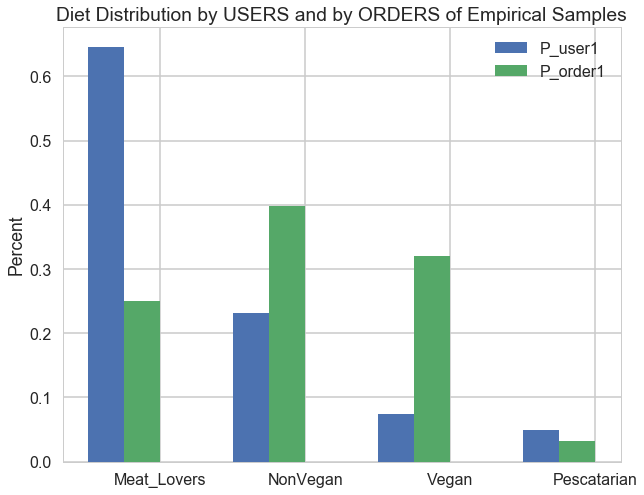

In [73]:
## This will graph Diet Distributions by USERS and by ORDERS using Empirical Samples
fig, ax = plt.subplots(figsize=(10,8))

X = np.arange(4)
plt.bar(X + 0.00, User_Order_Emp.Percent1, color = 'b', width = 0.25)
plt.bar(X + 0.25, User_Order_Emp.Percent2, color = 'g', width = 0.25)
plt.ylabel('Percent')

ax.set_xticks([p + 1.5 * 0.25 for p in X])
ax.set_xticklabels(User_Order_Emp.Diet)

plt.legend(['P_user1', 'P_order1'], loc='upper right')
plt.title('Diet Distribution by USERS and by ORDERS of Empirical Samples')
plt.show()

In [74]:
## pvalues, variances, standard deviation, % diff, moe, DF and t_values calculated to test Hypothesis I
Use_Or=diff_std_p_val(User_Order_Emp)
Use_Or

,Diet,Size1,Percent1,Size2,Percent2,var_1,var_2,var1_2,std_var1_2,%_diff,moe,DF,t_val,p_val
0,Meat_Lovers,19362,0.645400,116322,0.249738,0.000012,0.000002,0.000013,0.003665,0.395662,0.007183,20248.617207,107.962684,0.000000e+00
1,NonVegan,6952,0.231733,185377,0.397996,0.000026,0.000001,0.000027,0.005187,0.166263,0.010166,6978.340289,32.055878,1.839678e-210
2,Vegan,2230,0.074333,148928,0.319742,0.000031,0.000001,0.000032,0.005685,0.245408,0.011142,2233.162120,43.169822,1.419953e-296
3,Pescatarian,1456,0.048533,15149,0.032524,0.000032,0.000002,0.000034,0.005813,0.016009,0.011394,1474.381948,2.753950,5.960402e-03


### All p_values are <0.05, we can reject the null hypothesis and accept H1.  
H1:There is significant difference in classifying Diets between using "users overall orders" versus using "individual orders disregarding who ordered it" 

### Q12F. Hypothesis testing part 2: Are there significant differences between Diet distribution classified by USERS and by ORDERS using Empirical dataset vs. Simulated dataset
#### I.
Ho: There is no significant difference between Diet distribution classified by USERS using Empirical dataset versus Simulated dataset

H1: There is significant difference between Diet distribution classified by USERS using Empirical dataset versus Simulated dataset

In [75]:
## Sim_Emp_User is the dataframe comparing % of empirical sample and simulated sample both classified by USERS
Sim_Emp_User=df_prop_compare(P_user1, Psimulated_user)
Sim_Emp_User

,Diet,Size1,Percent1,Size2,Percent2
0,Meat_Lovers,19362,0.645400,24790,0.826223
1,NonVegan,6952,0.231733,3970,0.132316
2,Vegan,2230,0.074333,464,0.015465
3,Pescatarian,1456,0.048533,780,0.025997


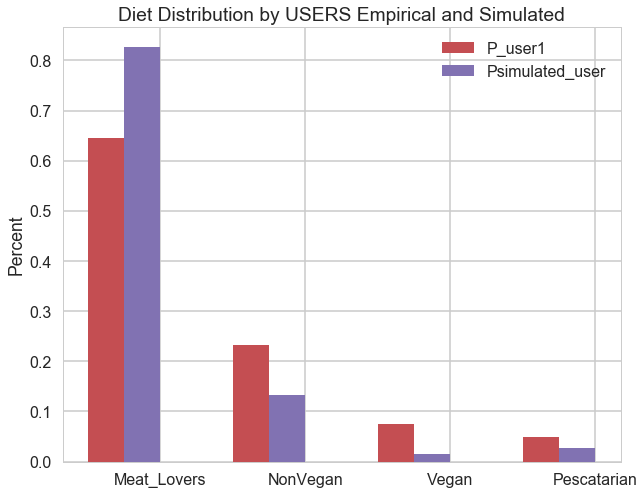

In [76]:
## This will graph Diet Distributions by USERS using Empirical Sample DataSet and Simulated Sample Dataset
fig, ax = plt.subplots(figsize=(10,8))

X = np.arange(4)
plt.bar(X + 0.00, Sim_Emp_User.Percent1, color = 'r', width = 0.25)
plt.bar(X + 0.25, Sim_Emp_User.Percent2, color = 'm', width = 0.25)
plt.ylabel('Percent')

ax.set_xticks([p + 1.5 * 0.25 for p in X])
ax.set_xticklabels(Sim_Emp_User.Diet)

plt.legend(['P_user1', 'Psimulated_user'], loc='upper right')
plt.title('Diet Distribution by USERS Empirical and Simulated')
plt.show()

In [77]:
## pvalues, variances, standard deviation, % diff, moe, DF and t_values calculated to test Hypothesis II  (by USERS)
Sim_Emp=diff_std_p_val(Sim_Emp_User)
Sim_Emp

,Diet,Size1,Percent1,Size2,Percent2,var_1,var_2,var1_2,std_var1_2,%_diff,moe,DF,t_val,p_val
0,Meat_Lovers,19362,0.645400,24790,0.826223,0.000012,0.000006,0.000018,0.004197,0.180823,0.008225,33217.910993,43.087604,0.000000e+00
1,NonVegan,6952,0.231733,3970,0.132316,0.000026,0.000029,0.000055,0.007384,0.099418,0.014473,7853.560575,13.463386,7.278022e-41
2,Vegan,2230,0.074333,464,0.015465,0.000031,0.000033,0.000064,0.007979,0.058869,0.015639,658.089968,7.377693,4.869627e-13
3,Pescatarian,1456,0.048533,780,0.025997,0.000032,0.000032,0.000064,0.008011,0.022537,0.015702,1578.507930,2.813190,4.966030e-03


### All p_values are <0.05, we can reject the null hypothesis and accept H1.  
H1: There is significant difference between Diet distribution classified by USERS using Empirical dataset versus Simulated dataset

#### II.
Ho: There is no significant difference between Diet distribution classified by ORDERS using Empirical dataset versus Simulated dataset

H1: There is significant difference between Diet distribution classified by ORDERS using Empirical dataset versus Simulated dataset

In [78]:
## Sim_Emp_Order is the dataframe comparing % of empirical sample and simulated sample both classified by ORDERS
Sim_Emp_Order=df_prop_compare(P_order1, Psimulated_order)
Sim_Emp_Order

,Diet,Size1,Percent1,Size2,Percent2
0,NonVegan,185377,0.397996,199142,0.427549
1,Vegan,148928,0.319742,121720,0.261327
2,Meat_Lovers,116322,0.249738,128179,0.275195
3,Pescatarian,15149,0.032524,16735,0.035929


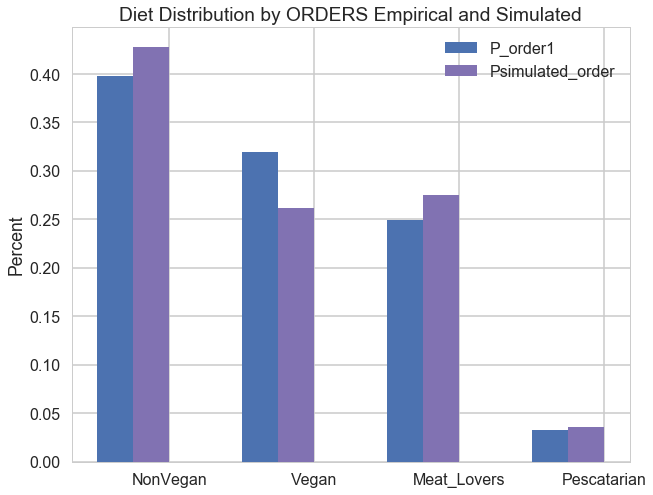

In [79]:
## This will graph Diet Distributions classified by ORDERS using Empirical and Simulated Sample Datasets
fig, ax = plt.subplots(figsize=(10,8))

X = np.arange(4)
plt.bar(X + 0.00, Sim_Emp_Order.Percent1, color = 'b', width = 0.25)
plt.bar(X + 0.25, Sim_Emp_Order.Percent2, color = 'm', width = 0.25)
plt.ylabel('Percent')

ax.set_xticks([p + 1.5 * 0.25 for p in X])
ax.set_xticklabels(Sim_Emp_Order.Diet)

plt.legend(['P_order1', 'Psimulated_order'], loc='upper right')
plt.title('Diet Distribution by ORDERS Empirical and Simulated')
plt.show()

In [80]:
##Sim_Emp_Order is a dataframe with calculated standard deviation, moe, degrees of freedom, t_values and p_values (ORDERS)
Sim_Emp_Order=diff_std_p_val(Sim_Emp_Order)
Sim_Emp_Order

,Diet,Size1,Percent1,Size2,Percent2,var_1,var_2,var1_2,std_var1_2,%_diff,moe,DF,t_val,p_val
0,NonVegan,185377,0.397996,199142,0.427549,0.000001,0.000001,0.000003,0.001588,0.029553,0.003112,380951.887901,18.610989,2.832964e-77
1,Vegan,148928,0.319742,121720,0.261327,0.000001,0.000002,0.000003,0.001745,0.058414,0.003421,255572.540218,33.467820,4.828091e-245
2,Meat_Lovers,116322,0.249738,128179,0.275195,0.000002,0.000002,0.000003,0.001780,0.025456,0.003488,241346.457049,14.304752,2.135091e-46
3,Pescatarian,15149,0.032524,16735,0.035929,0.000002,0.000002,0.000004,0.002036,0.003405,0.003991,31559.699730,1.672099,9.451467e-02


### For Meat_Lovers, NonVegan, and Vegan, p_values are <0.05, we can reject the null hypothesis and accept H1.¶
#### H1: There is significant difference between Diet distribution classified by ORDERS using Empirical dataset versus Simulated dataset.  
#### However for Pescatarian classified by ORDERS p_value>0.05 which means there is no significant difference in % of this group using Empirical dataset and Simulated dataset

## Q13. What is the probability that customer is in a Diet classification given that they purchased from aisle P(Diet|Aisle) (likelihood)? What is the probability that product is from an Aisle given that their Diet is known P(Aisle|Diet)?¶

In this section, I used Bayesian Statistics to calculate P(Diet|Aisle) and P(Aisle|Diet)

In [81]:
## TA is a dataframe with all orders and each user with Diet Classification
TA=E1.merge(C1)
TA1=TA[TA.Diet=='Meat_Lovers']
TA2=TA[TA.Diet=='Pescatarian']
TA3=TA[TA.Diet=='NonVegan']
TA4=TA[TA.Diet=='Vegan']

In [82]:
##Probaility of buying from aisles given that they are Meat_Lovers(P(aisle|Meat_Lovers))
Prob1=TA1.aisle_id.value_counts()
Prob1=pd.DataFrame(Prob1).reset_index()
Prob1.columns=['aisle_id', 'count1']
Prob1['Prob1']=Prob1['count1']/Prob1['count1'].sum()

In [83]:
##Probaility of buying from aisles given that they are Pescatarian (P(aisle|Pescatarian))
Prob2=TA2.aisle_id.value_counts()
Prob2=pd.DataFrame(Prob2).reset_index()
Prob2.columns=['aisle_id', 'count2']
Prob2['Prob2']=Prob2['count2']/Prob2['count2'].sum()

In [84]:
##Probaility of buying from aisle 1 given that they are NonVegan (P(aisle|NonVegan))
Prob3=TA3.aisle_id.value_counts()
Prob3=pd.DataFrame(Prob3).reset_index()
Prob3.columns=['aisle_id', 'count3']
Prob3['Prob3']=Prob3['count3']/Prob3['count3'].sum()

In [85]:
##Probaility of buying from aisle 1 given that they are Vegan (P(aisle|Vegan))
Prob4=TA4.aisle_id.value_counts()
Prob4=pd.DataFrame(Prob4).reset_index()
Prob4.columns=['aisle_id', 'count4']
Prob4['Prob4']=Prob4['count4']/Prob4['count4'].sum()

In [86]:
Pmeatlover=P_user1.iloc[0,2]
Pnonvegan=P_user1.iloc[1,2]
Pvegan=P_user1.iloc[2,2]
Pescatarian=P_user1.iloc[3,2]

In [87]:
Pall=Prob1.merge(Prob2).merge(Prob3).merge(Prob4).merge(aisle_percentb)

In [88]:
Pall['P(meat_lover|aisle)']=Pall.Prob1*Pmeatlover/Pall.aisle_percent_prior
Pall['P(pescatarian|aisle)']=Pall.Prob2*Pescatarian/Pall.aisle_percent_prior
Pall['P(nonvegan|aisle)']=Pall.Prob3*Pnonvegan/Pall.aisle_percent_prior
Pall['P(vegan|aisle)']=Pall.Prob4*Pvegan/Pall.aisle_percent_prior

In [89]:
Pall=Pall.set_index('aisle_id').sort_index().reset_index()
Pall

,aisle_id,count1,Prob1,count2,Prob2,count3,Prob3,count4,Prob4,aisle_percent_prior,P(meat_lover|aisle),P(pescatarian|aisle),P(nonvegan|aisle),P(vegan|aisle)
0,1,8537,0.002238,381,0.002304,1233,0.001947,80,0.001101,0.002218,0.651214,0.050414,0.203469,0.036893
1,3,47769,0.012521,1756,0.010617,13747,0.021709,1604,0.022068,0.014071,0.574289,0.036620,0.357527,0.116582
2,4,25157,0.006594,755,0.004565,2238,0.003534,200,0.002752,0.006187,0.687791,0.035806,0.132365,0.033057
3,6,3849,0.001009,126,0.000762,855,0.001350,151,0.002078,0.001119,0.581923,0.033044,0.279641,0.138018
4,8,3863,0.001013,166,0.001004,873,0.001379,114,0.001568,0.001075,0.607823,0.045308,0.297155,0.108442
5,9,27511,0.007211,903,0.005460,2712,0.004283,190,0.002614,0.006733,0.691188,0.039354,0.147400,0.028859
6,10,1005,0.000263,62,0.000375,174,0.000275,30,0.000413,0.000283,0.601200,0.064336,0.225174,0.108496
7,11,2753,0.000722,150,0.000907,678,0.001071,116,0.001596,0.000803,0.579605,0.054781,0.308796,0.147647
8,12,4605,0.001207,153,0.000925,505,0.000797,29,0.000399,0.001132,0.687956,0.039649,0.163207,0.026192
9,13,11661,0.003056,280,0.001693,1696,0.002678,114,0.001568,0.003053,0.646066,0.026910,0.203275,0.038185


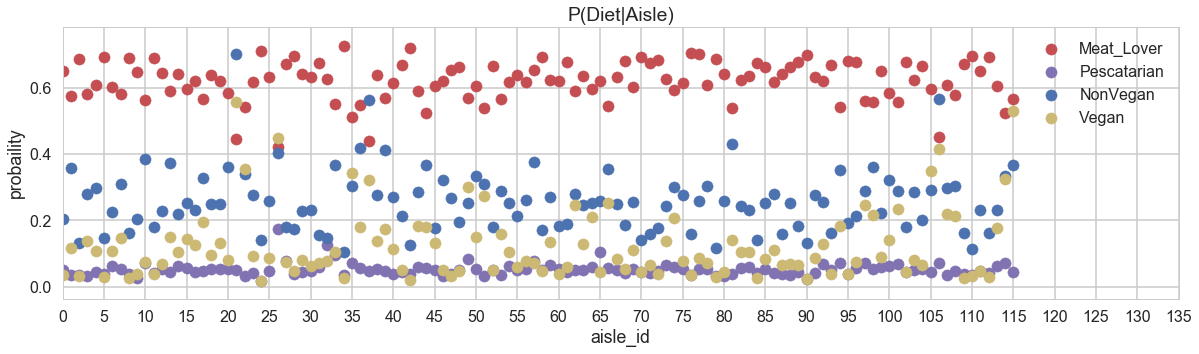

In [90]:
## This graphs the Aisle number vs P(Diet|Aisle)
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(range(len(Pall['P(meat_lover|aisle)'])), Pall['P(meat_lover|aisle)'], color='r')
plt.scatter(range(len(Pall['P(pescatarian|aisle)'])), Pall['P(pescatarian|aisle)'], color='m')
plt.scatter(range(len(Pall['P(nonvegan|aisle)'])), Pall['P(nonvegan|aisle)'], color='b')
plt.scatter(range(len(Pall['P(vegan|aisle)'])), Pall['P(vegan|aisle)'], color='y')
plt.xlim(0,135)
plt.xlabel('aisle_id')
plt.ylabel('probaility')
plt.title('P(Diet|Aisle)')
plt.legend(['Meat_Lover', 'Pescatarian', 'NonVegan', 'Vegan'], loc='upper right')
ax.set_xticks(np.arange(0,136,5))
plt.show()

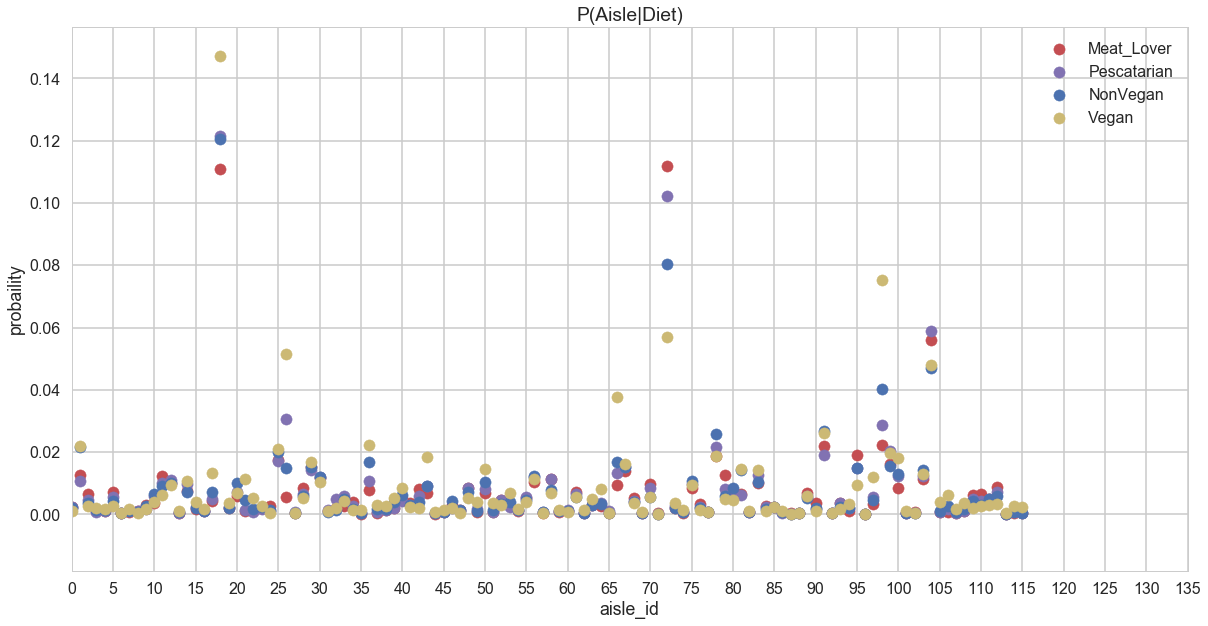

In [91]:
## This graphs aisle number vs P(Aisle|Diet)
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(range(len(Pall['Prob1'])), Pall['Prob1'], color='r')
plt.scatter(range(len(Pall['Prob2'])), Pall['Prob2'], color='m')
plt.scatter(range(len(Pall['Prob3'])), Pall['Prob3'], color='b')
plt.scatter(range(len(Pall['Prob4'])), Pall['Prob4'], color='y')
plt.xlim(0,135)
plt.xlabel('aisle_id')
plt.ylabel('probaility')
plt.title('P(Aisle|Diet)')
plt.legend(['Meat_Lover', 'Pescatarian', 'NonVegan', 'Vegan'], loc='upper right')
ax.set_xticks(np.arange(0,136,5))
plt.show()

## Q14. What products appear in all customer A orders? – These products will have high probability being reordered by customer A
allprior dataframe must be used here since Alltrain only have 1 order per user with no order history

In [92]:
## Percent of products reordered in allprior DataFrame
allprior[allprior.reordered==1].shape[0]/allprior.shape[0]

0.5896974667922161

In [93]:
## Percent of products not reordered in Allprior DataFrame
allprior[allprior.reordered==0].shape[0]/allprior.shape[0]

0.41030253320778387

In [94]:
## Percent of products reordered in Alltrain DataFrame
alltrain[alltrain.reordered==1].shape[0]/alltrain.shape[0]

0.5985944127509629

In [95]:
## Percent of products not reordered in Alltrain DataFrame
alltrain[alltrain.reordered==0].shape[0]/alltrain.shape[0]

0.4014055872490371

In [96]:
Reorder_prior=allprior[allprior.reordered==1]

In [97]:
## Products reordered by each users in allprior dataframe. Products with highest reorder count have highest probability of being reordered
allprior[allprior.reordered==1].groupby('user_id')['product_name'].value_counts()

user_id  product_name                                                                            
1        Original Beef Jerky                                                                         9
         Soda                                                                                        9
         Pistachios                                                                                  8
         Organic String Cheese                                                                       7
         Cinnamon Toast Crunch                                                                       2
         Zero Calorie Cola                                                                           2
         Aged White Cheddar Popcorn                                                                  1
         Bag of Organic Bananas                                                                      1
         Organic Half & Half                                                  

## Q15. How many orders for each customer?

In [98]:
allprior.groupby('user_id')['order_number'].max()

user_id
1         10
2         14
3         12
4          5
5          4
6          3
7         20
8          3
9          3
10         5
11         7
12         5
13        12
14        13
15        22
16         6
17        40
18         6
19         9
20         4
21        33
22        15
23         4
24        18
25         3
26        12
27        81
28        24
29        18
30         8
          ..
206180    18
206181    14
206182    10
206183    14
206184     4
206185    10
206186     3
206187    34
206188     7
206189     6
206190     8
206191     5
206192    14
206193    41
206194    11
206195    19
206196     4
206197    23
206198     7
206199    19
206200    23
206201    32
206202    22
206203     5
206204     4
206205     3
206206    67
206207    16
206208    49
206209    13
Name: order_number, dtype: int64

## Q16. What is the average number of products for each customer per order

### Using Train dataframe

In [99]:
alltrain.groupby('order_id')['product_name'].size().mean()   ## overall average products per order

10.552759338155157

In [100]:
alltrain.groupby('user_id')['order_id'].size().head()     # number of products ordered per customer


user_id
1    11
2    31
5     9
7     9
8    18
dtype: int64

### Using allprior dataframe

In [101]:
allprior.groupby('order_id')['product_name'].size().mean()

10.088883421247614

In [102]:
allprior.groupby('user_id')['order_id'].size().head()

user_id
1     59
2    195
3     88
4     18
5     37
dtype: int64

## Q17. Using average number of product per order for each customer and probability of product to be reordered by customer, can I predict products that will be reordered by customer?
What is the accuracy of my predicted next order list to the actual next order list?

In [103]:
Users1=otrain.user_id.sample(n=20000, replace=False, random_state=0, axis=0)

In [104]:
User_train=allprior.loc[allprior.user_id.isin(Users1)]

In [105]:
## U_order_train is the dataframe of User_train with their number of orders
U_order_train=User_train.groupby('user_id')['order_number'].agg(['max'])
U_order_train['user_id']=U_order_train.index.get_level_values('user_id').values
U_order_train.columns=['max_order', 'user_id']

### F9. This function produce a dataframe with predicted orders per user

In [106]:
def predict_orders(Use_Or):  
    ##Train Data with user_id and latest product ordered
    ytrain=Use_Or.loc[:,['user_id', 'product_id']]
    ytrain.columns=['user_id', 'product_id_latest_train']
    
    ##Number of products in latest order (Training Data)
    Tr=ytrain.user_id.value_counts()
    Tr=pd.DataFrame(Tr).reset_index()
    Tr.columns=['user_id', 'tQty']

    ## DataFrame with the users in  with product_id and Qty of product_id purchased
    R=Use_Or.groupby('user_id')['product_id'].value_counts()
    R=pd.DataFrame(R)
    R.columns=['Qty']
    R=R.reset_index()
    
    ##DataFrame with average product per order
    Q=Use_Or.groupby(['user_id', 'order_id'])['product_id'].size()
    Q=pd.DataFrame(Q)

    Q=Q.reset_index()
    p=Q.groupby('user_id')[0].mean()
    p=pd.DataFrame(p)
    p.columns=['ave_prod_per_order']
    p=p.reset_index()
    Q=Q.merge(p)
    Q['ave_prod_per_order']=Q['ave_prod_per_order'].round(decimals=0)
    Q=Q.loc[:,['user_id','order_id', 'ave_prod_per_order']]
    Q=Q.loc[:,['user_id', 'ave_prod_per_order']].drop_duplicates()

    ## Dataframe with user_id and total product purchased
    total_products=Use_Or.user_id.value_counts()
    total_products=pd.DataFrame(total_products)
    total_products.reset_index(inplace=True)
    total_products.columns=['user_id', 'total_products']
    total_products.drop_duplicates(inplace=True)
    
    ## This will compute probability of products to be purchased by user
    R=R.merge(total_products)
    R['Prob']=R.Qty/R.total_products
    
    ## This will predict next order list using calculated probabilities of products for each user and using average product per order
    B=[]
    user=pd.Series.tolist(Q.user_id)
    n=pd.Series.tolist(Q.ave_prod_per_order) ## This is a list of average product per order per user

    i=0
    for i in range(len(n)):
        H=R[R.user_id==user[i]]
        K=np.random.choice(a=H.product_id, size=n[i], p=H.Prob, replace=False)
        K=K.tolist()
        B.append(K)
        i+=1
    ## This is the predicted latest order
    Reord=pd.DataFrame(B, index=Q.user_id).stack()
    Reord=pd.DataFrame(Reord, columns=['product_id'])
    Reord=Reord.reset_index()
    Reord.drop('level_1', axis=1, inplace=True)
    
    return Reord

In [107]:
U_pred=predict_orders(User_train)
U_pred

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,user_id,product_id
0,27,33787.0
1,27,40709.0
2,27,24852.0
3,27,20794.0
4,27,10912.0
5,27,32263.0
6,27,20119.0
7,27,33370.0
8,27,19008.0
9,34,7054.0


### F10. This function reformats dataframe with predicted products two columns where predicted products are all written accross the user_id

In [108]:
def predicted_product_format(predicted):
    pred = ''
    for product in predicted:
        if product > 0:
            pred = pred + str(int(product)) + ' '
    
    if pred != '':
        return pred.rstrip()
    else:
        return 'None'

In [109]:
# this creates a DataFrame of user_id and predicted product_id list 
predicted_order = pd.DataFrame(U_pred.groupby('user_id')["product_id"].apply(predicted_product_format)).reset_index()
predicted_order

,user_id,product_id
0,27,33787 40709 24852 20794 10912 32263 20119 3337...
1,34,7054 5134 19514 3098 15604 38273
2,44,28378 26505 1073 21616 9121 27156 35042 35353 ...
3,62,12745 47209 28289 34584 24852 38288 24184 36011
4,64,20583 47209 40723 44008 4920 30391 37029 9786 ...
5,71,17200 28720 9839 38739 32537 29662 48857 25705...
6,81,6184 22362 8048 30720
7,84,14678 45535 48595 3896 9000 28373 23165 4086
8,90,49520 1831 8490 1782 32648 36316 6069 10180 32293
9,99,13176 15153 26209 18171 24654 24221 2295 5132 ...


In [110]:
## This generates the actual product ordered of Users1 in alltrain dataset
train_order = pd.DataFrame(User_train.groupby('user_id')["product_id"].apply(predicted_product_format)).reset_index()
train_order.columns=['user_id', 'product_id_train']

In [111]:
combine_pred_train=predicted_order.merge(train_order)
combine_pred_train

,user_id,product_id,product_id_train
0,27,33787 40709 24852 20794 10912 32263 20119 3337...,16290 16290 16290 16290 16290 16290 16290 1629...
1,34,7054 5134 19514 3098 15604 38273,25146 3957 3957 3957 33731 7054 7054 15604 156...
2,44,28378 26505 1073 21616 9121 27156 35042 35353 ...,47141 1263 43632 26172 26172 23341 26505 44560...
3,62,12745 47209 28289 34584 24852 38288 24184 36011,45223 26620 26620 26620 31618 12745 37947 3794...
4,64,20583 47209 40723 44008 4920 30391 37029 9786 ...,18811 18811 18811 18811 25146 49052 21475 1494...
5,71,17200 28720 9839 38739 32537 29662 48857 25705...,19730 19730 19730 19730 19730 19730 19730 1973...
6,81,6184 22362 8048 30720,196 196 14715 19887 17902 17902 22362 13176 13...
7,84,14678 45535 48595 3896 9000 28373 23165 4086,36127 44632 12576 49191 49520 49520 49520 4952...
8,90,49520 1831 8490 1782 32648 36316 6069 10180 32293,36316 36316 36316 36316 36316 36316 36316 3631...
9,99,13176 15153 26209 18171 24654 24221 2295 5132 ...,23208 23208 15153 33543 33956 35336 35336 1763...


### F11. This function calculates cosine similarity score

In [112]:
from collections import Counter
import math
## Cosine similarity function to compare % similarities in the train and predicted products

def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)


In [121]:
 i=0
cs=[]
st=combine_pred_train.product_id_train.values.tolist()
sp=combine_pred_train.product_id.values.tolist()

### F12. This function calculates cosine similarity score for all rows in the dataframe with columns of predicting and training order lists

In [122]:
def cos_sim_score(D):
    for i in range(len(st)):
        st[i]=st[i].split()
        sp[i]=sp[i].split()
        a=Counter(st[i])
        b=Counter(sp[i])
        cs.append(counter_cosine_similarity(a,b))
        i+=1
    return pd.Series(cs)

In [123]:
combine_pred_train['cosine_similarity_score']=cos_sim_score(combine_pred_train)
combine_pred_train

,user_id,product_id,product_id_train,cosine_similarity_score
0,27,33787 40709 24852 20794 10912 32263 20119 3337...,16290 16290 16290 16290 16290 16290 16290 1629...,0.213571
1,34,7054 5134 19514 3098 15604 38273,25146 3957 3957 3957 33731 7054 7054 15604 156...,0.541736
2,44,28378 26505 1073 21616 9121 27156 35042 35353 ...,47141 1263 43632 26172 26172 23341 26505 44560...,0.634441
3,62,12745 47209 28289 34584 24852 38288 24184 36011,45223 26620 26620 26620 31618 12745 37947 3794...,0.406745
4,64,20583 47209 40723 44008 4920 30391 37029 9786 ...,18811 18811 18811 18811 25146 49052 21475 1494...,0.472918
5,71,17200 28720 9839 38739 32537 29662 48857 25705...,19730 19730 19730 19730 19730 19730 19730 1973...,0.518357
6,81,6184 22362 8048 30720,196 196 14715 19887 17902 17902 22362 13176 13...,0.381246
7,84,14678 45535 48595 3896 9000 28373 23165 4086,36127 44632 12576 49191 49520 49520 49520 4952...,0.531250
8,90,49520 1831 8490 1782 32648 36316 6069 10180 32293,36316 36316 36316 36316 36316 36316 36316 3631...,0.482876
9,99,13176 15153 26209 18171 24654 24221 2295 5132 ...,23208 23208 15153 33543 33956 35336 35336 1763...,0.417734


In [124]:
combine_pred_train.cosine_similarity_score.mean()

0.5243686439250609

### F13. These two functions calculates F1 score for each row of a dataframe with predicted and training set of next order list

In [125]:
def f1_score_single(y_true, y_pred):
    y_true = set(y_true)
    y_pred = set(y_pred)
    cross_size = len(y_true & y_pred)
    if cross_size == 0: return 0.
    p = 1. * cross_size / len(y_pred)
    r = 1. * cross_size / len(y_true)
    return 2 * p * r / (p + r)
    
def f1_score(y_true, y_pred):
    return np.mean([f1_score_single(x, y) for x, y in zip(y_true, y_pred)])


In [126]:
i=0
F=[]
for i in range(len(st)):
    a=[]
    b=[]
    a.append(st[i])
    b.append(sp[i])
    f1=f1_score(a, b)
    F.append(f1)
    i+=1            

In [127]:
combine_pred_train['F1_score']=pd.Series(F)
combine_pred_train

,user_id,product_id,product_id_train,cosine_similarity_score,F1_score
0,27,33787 40709 24852 20794 10912 32263 20119 3337...,16290 16290 16290 16290 16290 16290 16290 1629...,0.213571,0.078603
1,34,7054 5134 19514 3098 15604 38273,25146 3957 3957 3957 33731 7054 7054 15604 156...,0.541736,0.375000
2,44,28378 26505 1073 21616 9121 27156 35042 35353 ...,47141 1263 43632 26172 26172 23341 26505 44560...,0.634441,0.571429
3,62,12745 47209 28289 34584 24852 38288 24184 36011,45223 26620 26620 26620 31618 12745 37947 3794...,0.406745,0.262295
4,64,20583 47209 40723 44008 4920 30391 37029 9786 ...,18811 18811 18811 18811 25146 49052 21475 1494...,0.472918,0.394366
5,71,17200 28720 9839 38739 32537 29662 48857 25705...,19730 19730 19730 19730 19730 19730 19730 1973...,0.518357,0.304000
6,81,6184 22362 8048 30720,196 196 14715 19887 17902 17902 22362 13176 13...,0.381246,0.333333
7,84,14678 45535 48595 3896 9000 28373 23165 4086,36127 44632 12576 49191 49520 49520 49520 4952...,0.531250,0.307692
8,90,49520 1831 8490 1782 32648 36316 6069 10180 32293,36316 36316 36316 36316 36316 36316 36316 3631...,0.482876,0.209302
9,99,13176 15153 26209 18171 24654 24221 2295 5132 ...,23208 23208 15153 33543 33956 35336 35336 1763...,0.417734,0.173913


In [128]:
np.mean(F)

0.3485425651973672